<a href="https://colab.research.google.com/github/Michael-HK/mlops-loan_approval_model/blob/main/loan_approval_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dabl
!pip install imbalanced-learn
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 10.2 MB/s eta 0:00:00


## Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import dabl
import pickle
from pickle import dump
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

colors = ['#97C1A9','#FFFFFF']

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function() {
    return False;
}

<IPython.core.display.Javascript object>

## Data Ingest and curation

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# change directory to the job folder
%cd /content/drive/My Drive/end_2_end_ML/loan_approval_prediction

/content/drive/My Drive/end_2_end_ML/loan_approval_prediction


In [8]:
df=pd.read_csv("LoanApprovalPrediction.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [9]:
#============= check shape ==================
df.shape

(614, 13)

In [10]:
# Check for data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [11]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [12]:
##==== check for nan ===========

df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
##========== fill nan present in the whole datasets =================

df.LoanAmount=df['LoanAmount'].fillna(df.LoanAmount.mean())

df.Credit_History=df['Credit_History'].fillna(df.Credit_History.mean())

df.Loan_Amount_Term=df['Loan_Amount_Term'].fillna(df.Loan_Amount_Term.mean())

df['Gender'].fillna(df['Gender'].value_counts().idxmax(), inplace=True)

df['Married'].fillna(df['Married'].value_counts().idxmax(), inplace=True)

df.Dependents.fillna(df['Dependents'].value_counts().idxmax(), inplace=True)

df.Self_Employed.fillna(df['Self_Employed'].value_counts().idxmax(), inplace=True)

In [14]:
##========== replace N and Y with binary ==========
df.Loan_Status.replace('N',0,inplace=True)
df.Loan_Status.replace('Y',1,inplace=True)

In [13]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ KB


In [16]:
#======== drop ID column ==================
df.drop(['Loan_ID'],inplace=True, axis=1)
df.reset_index(drop=True ,inplace=True)

## Initial data exploration

Target looks like classification
Linear Discriminant Analysis training set score: 0.708


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='Loan_Status'>,
 [array([[<Axes: ylabel='ApplicantIncome'>, <Axes: >, <Axes: >, <Axes: >],
         [<Axes: ylabel='CoapplicantIncome'>, <Axes: >, <Axes: >, <Axes: >],
         [<Axes: ylabel='LoanAmount'>, <Axes: >, <Axes: >, <Axes: >],
         [<Axes: xlabel='ApplicantIncome', ylabel='Credit_History'>,
          <Axes: xlabel='CoapplicantIncome'>, <Axes: xlabel='LoanAmount'>,
          <Axes: xlabel='Credit_History'>]], dtype=object),
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 640x480 with 1 Axes>],
 array([[<Axes: title={'center': 'Loan_Amount_Term'}>,
         <Axes: title={'center': 'Property_Area'}>,
         <Axes: title={'center': 'Married'}>,
         <Axes: title={'center': 'Education'}>],
        [<Axes: title={'center': 'Dependents'}>,
         <Axes: title={'center': 'Gender'}>,
         <Axes: title={'center': 'Self_Employed'}>, <Axes: >]],
       dtype=object)]

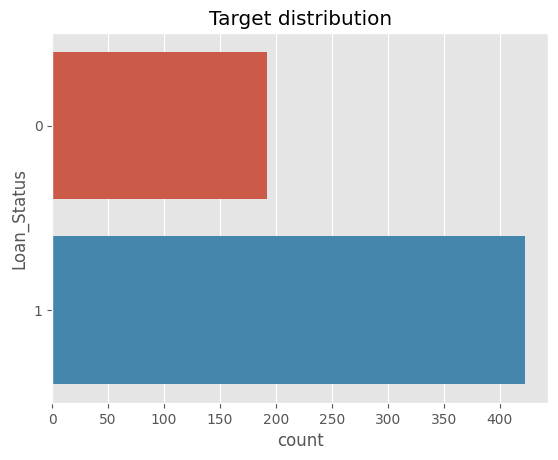

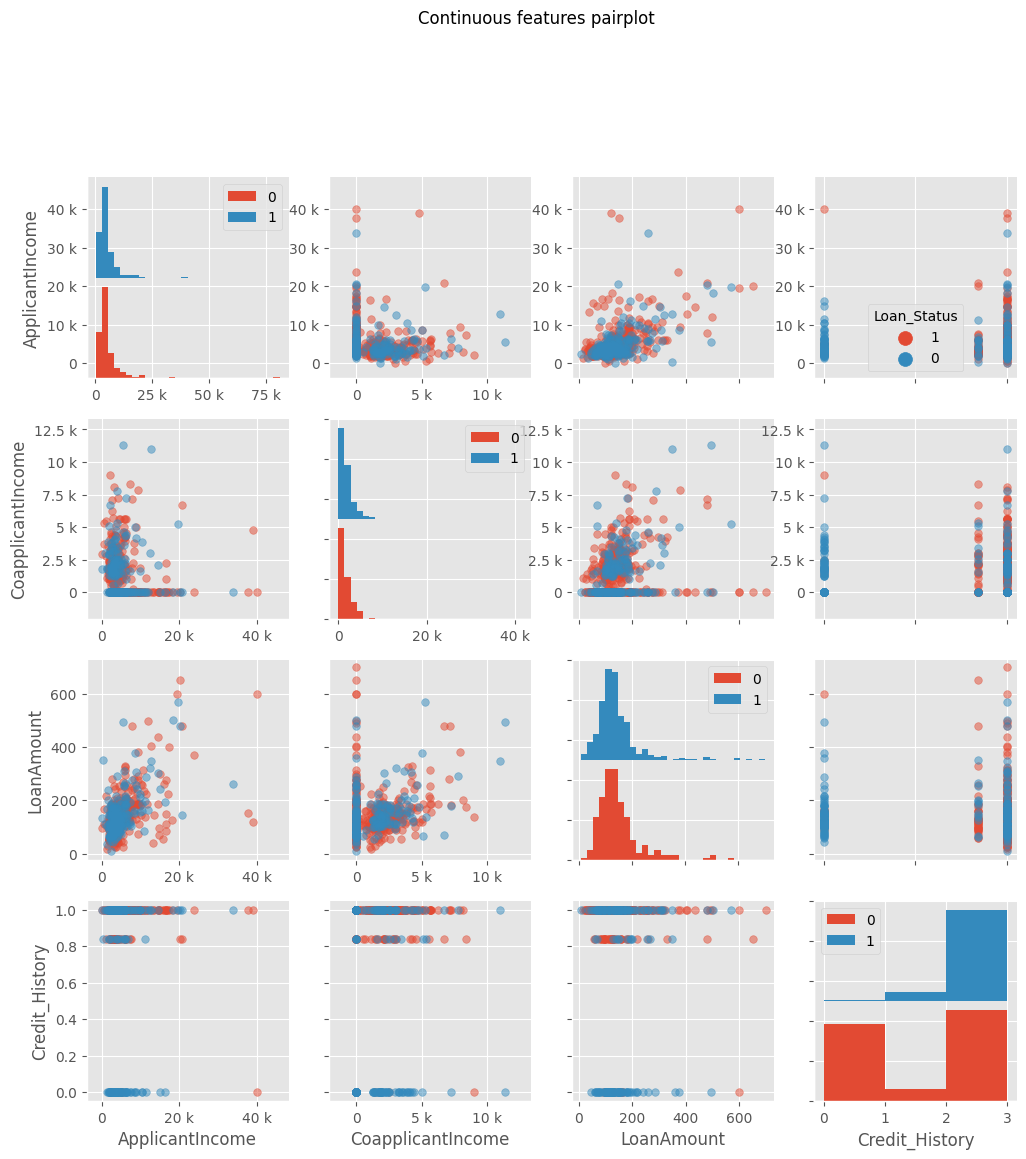

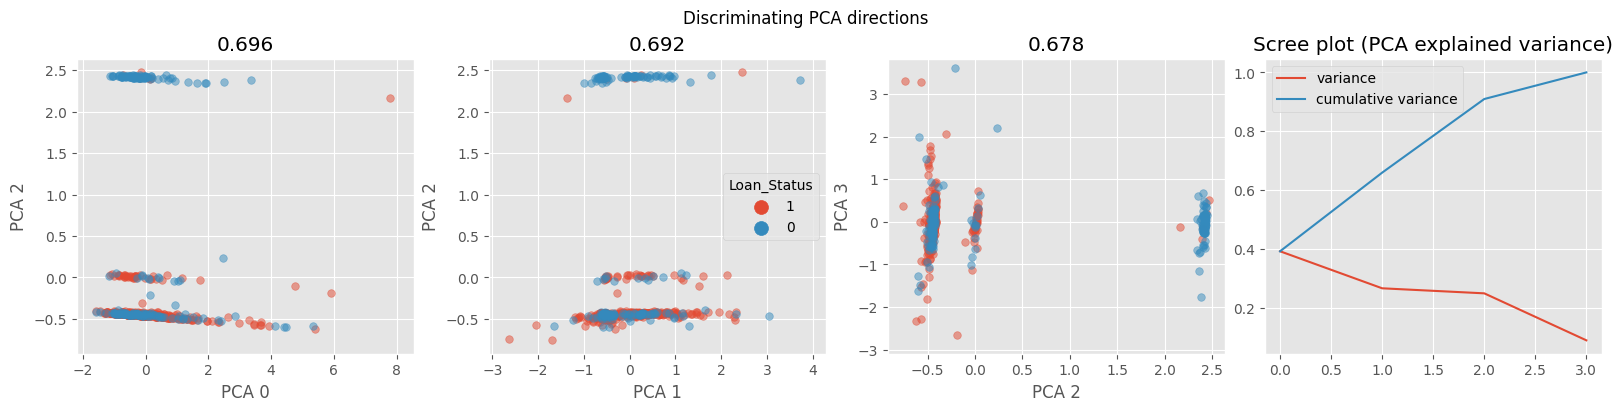

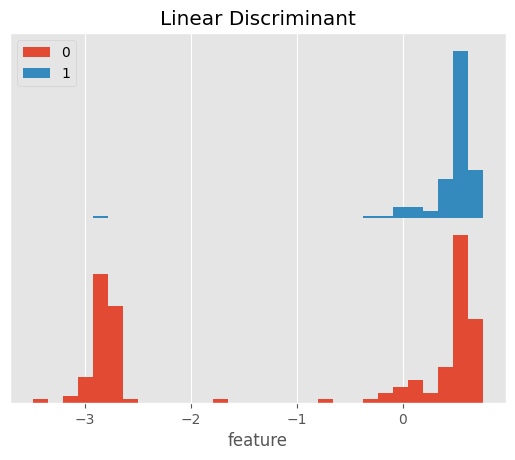

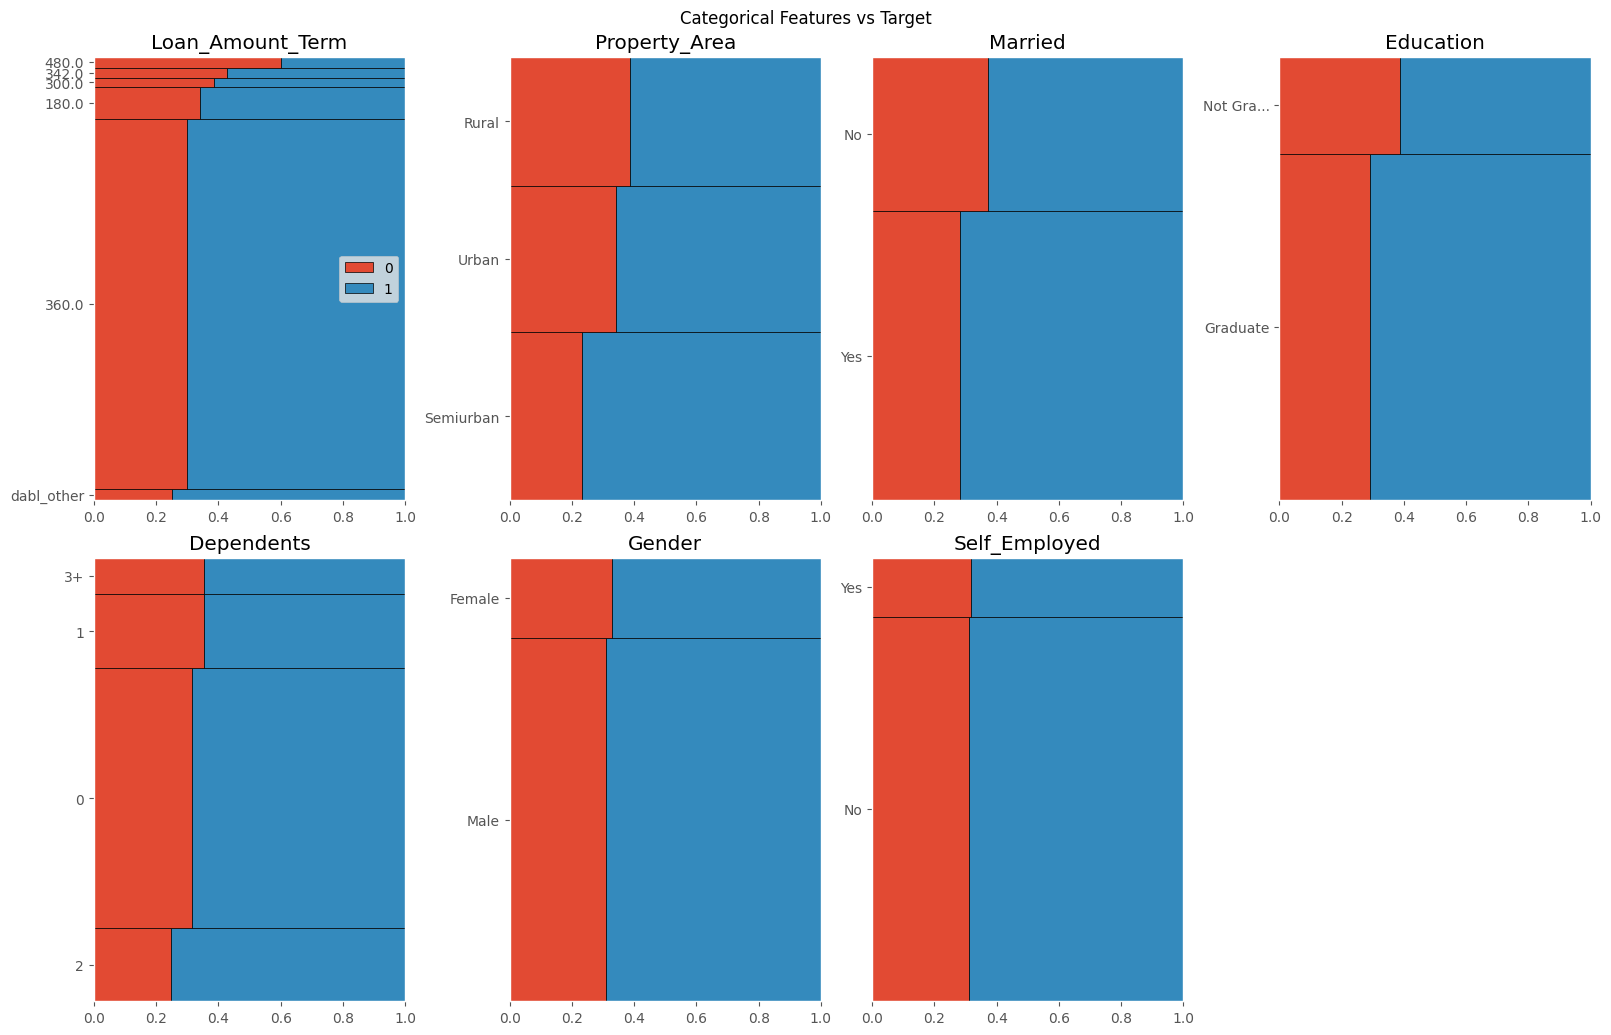

In [17]:
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
dabl.plot(df, target_col = 'Loan_Status')

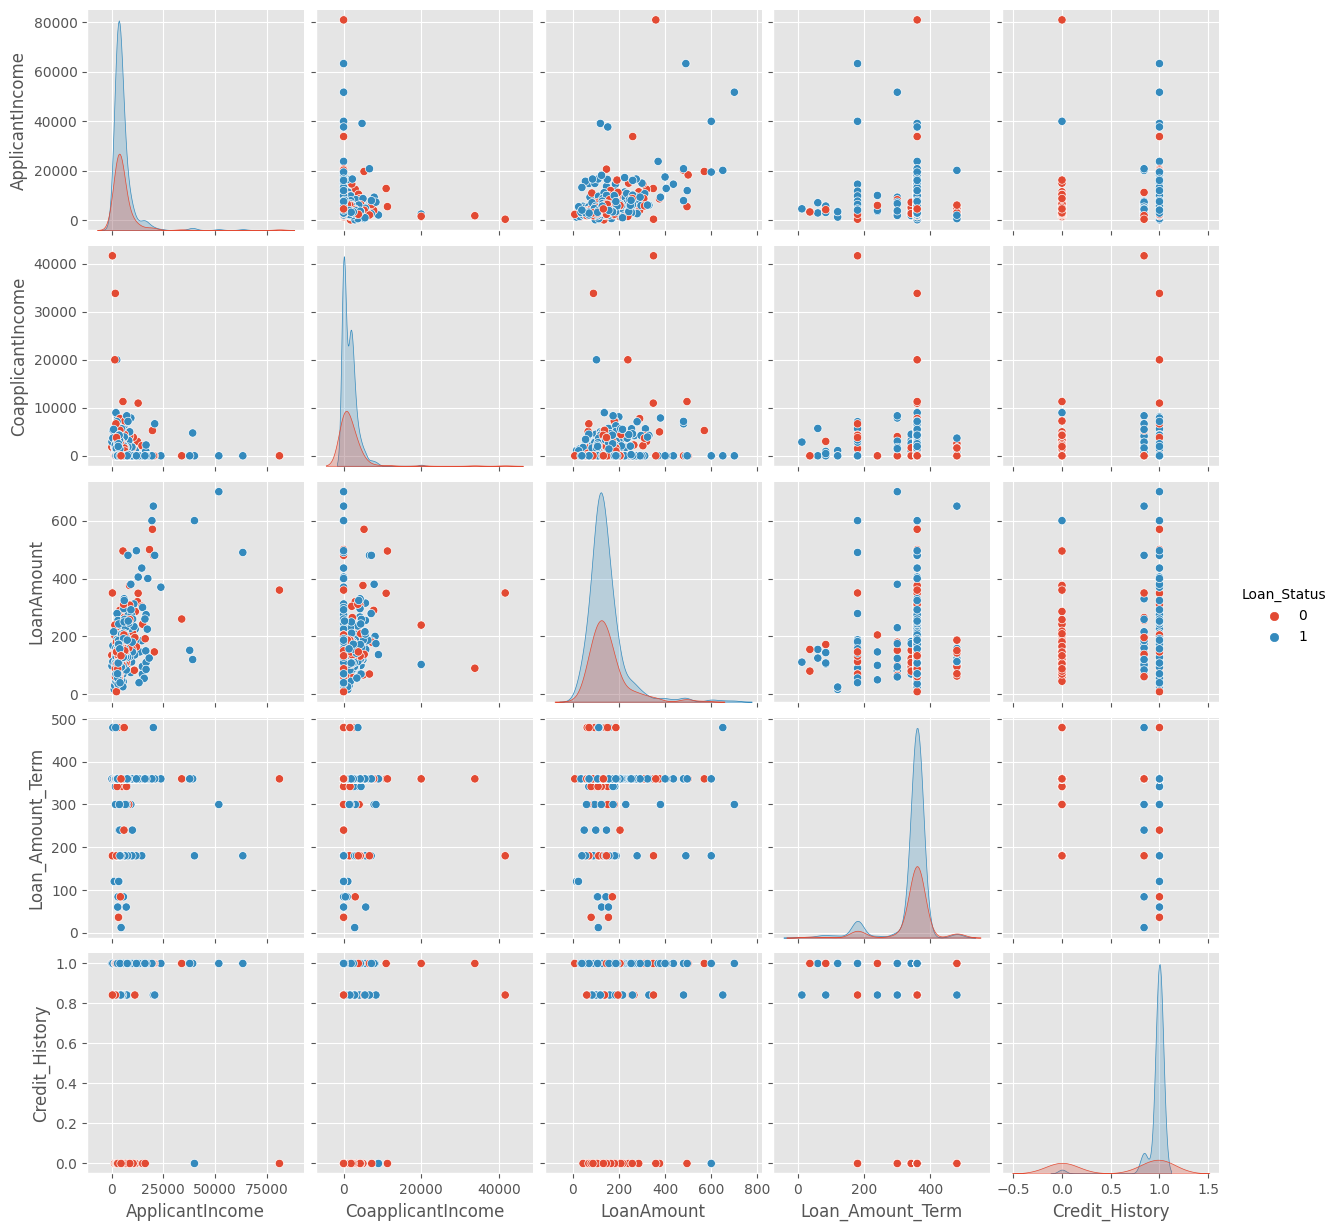

In [18]:
sns.pairplot(df, hue='Loan_Status')

### Explanatory Data Analysis

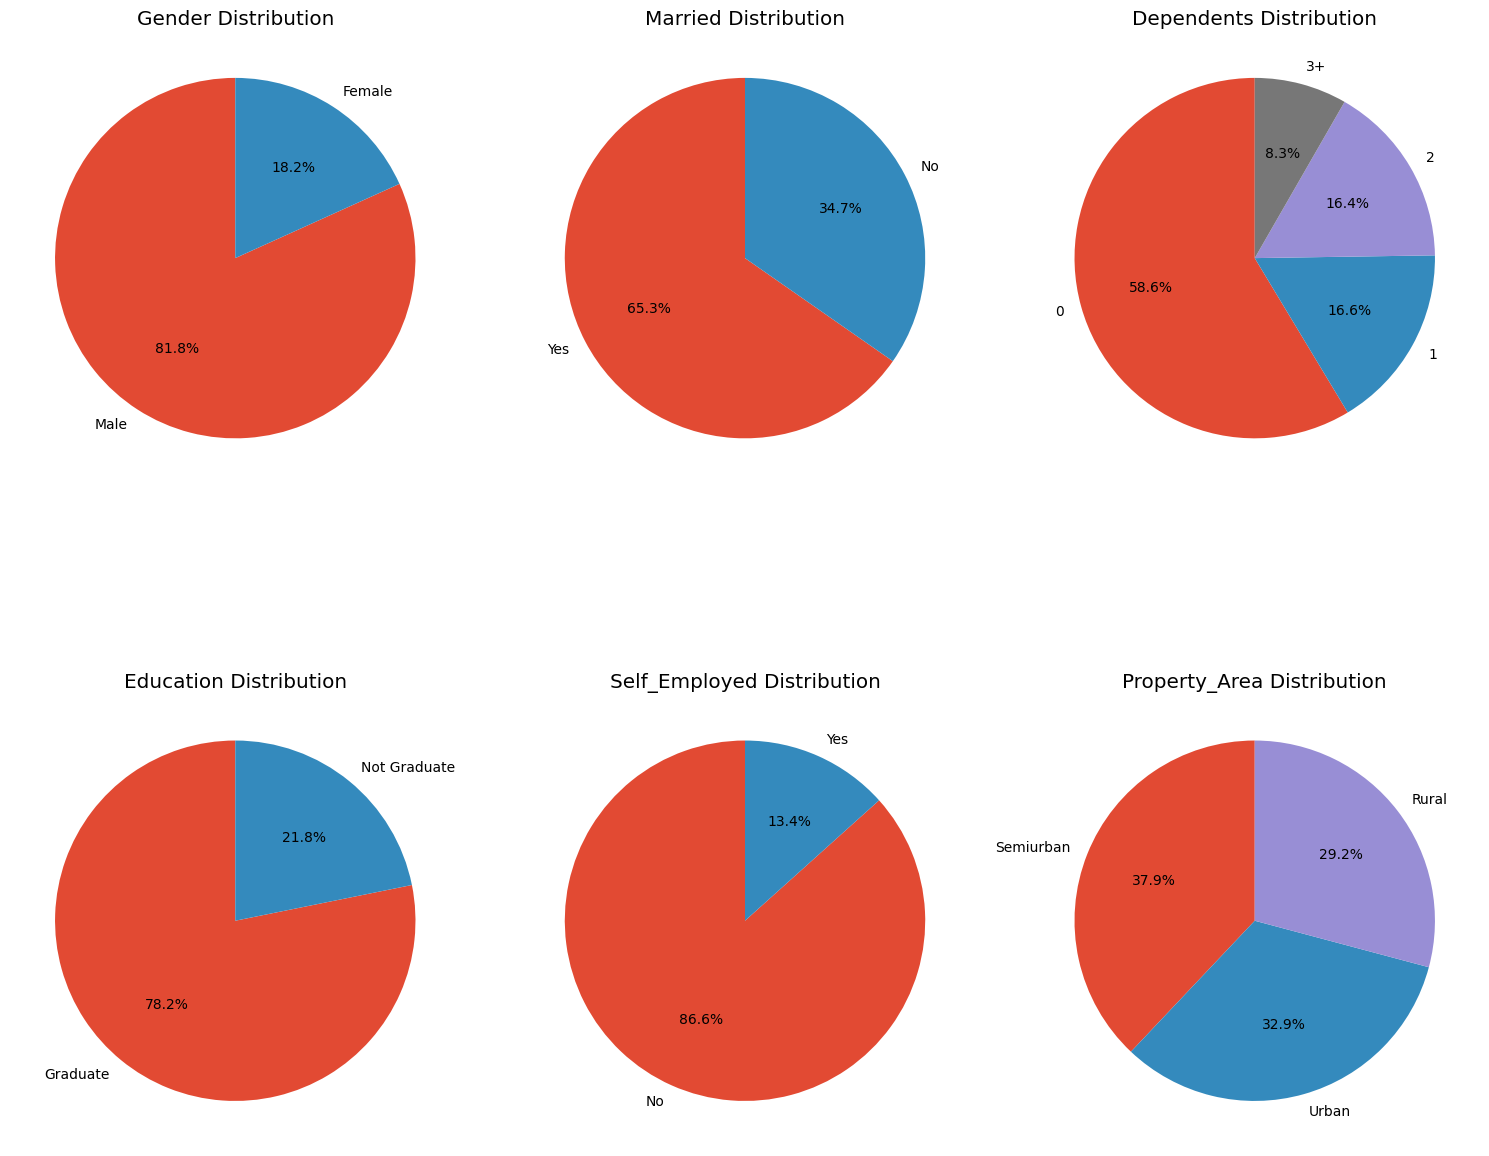

In [19]:
cat_var = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,15))

## create pie chart for each categories variables
for i, var in enumerate(cat_var):
  if i < len(axs.flat):
    # count the number of occurence in each category
    cat_counts = df[var].value_counts()

    #create pie
    axs.flat[i].pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', startangle=90)
    #set a title
    axs.flat[i].set_title(f'{var} Distribution')

# adjust spacing
fig.tight_layout()

#show the plot
plt.show()

In [20]:
print(list(df.select_dtypes(include=['object']).columns))

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [ ]:
#==============create figure with subplots====================

fig, axis = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
axs = axs.flatten()
for i, var in enumerate(list(df.select_dtypes(include=['object']).columns)):
  sns.countplot(x=var, hue='Loan_Status', data=df, ax=axis[i])
  axs[i].set_xticklabels(axis[i].get_xticklabels(), rotation=90)
fig.tight_layout()

In [ ]:
#===============create figure with subplots============================

fig, axis = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

for i, var in enumerate(df.select_dtypes(include=['object']).columns):
  sns.histplot(x=var, hue='Loan_Status', data=df, ax=axis[i], multiple='fill', kde=False, elements='bar')
  axs[i].set_xticklabels(axis[i].get_xticklabels(), rotation=90)

fig.tight_layout()

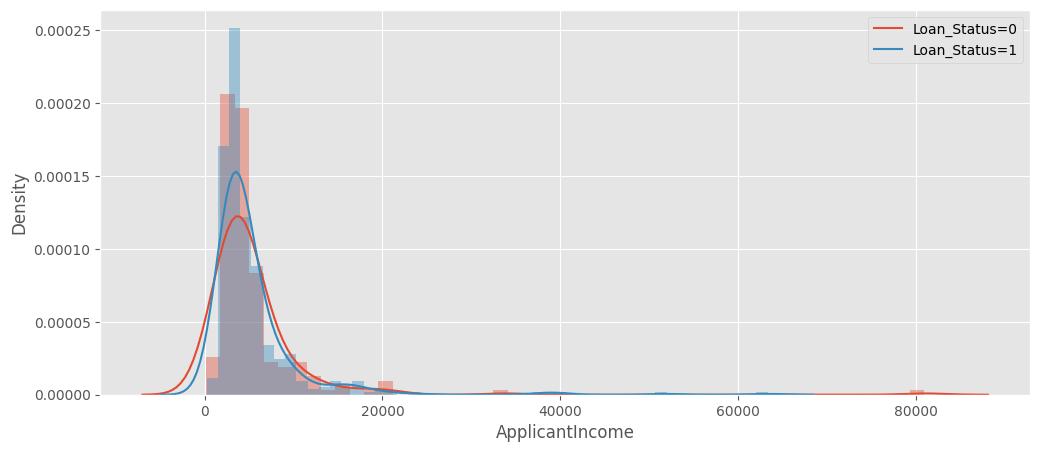

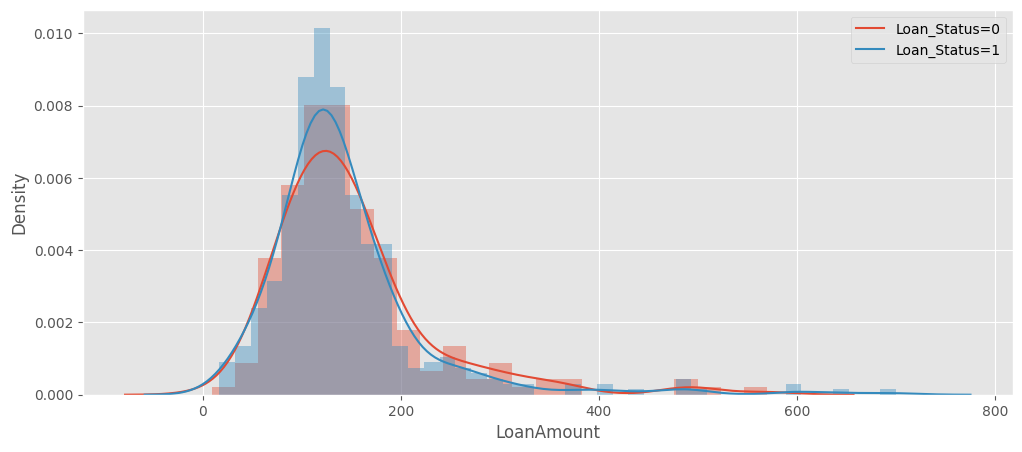

In [21]:
plt.figure(figsize=(12,5))
sns.distplot(df['ApplicantIncome'][df.Loan_Status==0])
sns.distplot(df['ApplicantIncome'][df.Loan_Status==1])
plt.legend(['Loan_Status=0','Loan_Status=1'])
plt.show()

plt.figure(figsize=(12,5))
sns.distplot(df['LoanAmount'][df.Loan_Status==0])
sns.distplot(df['LoanAmount'][df.Loan_Status==1])
plt.legend(['Loan_Status=0','Loan_Status=1'])
plt.show()

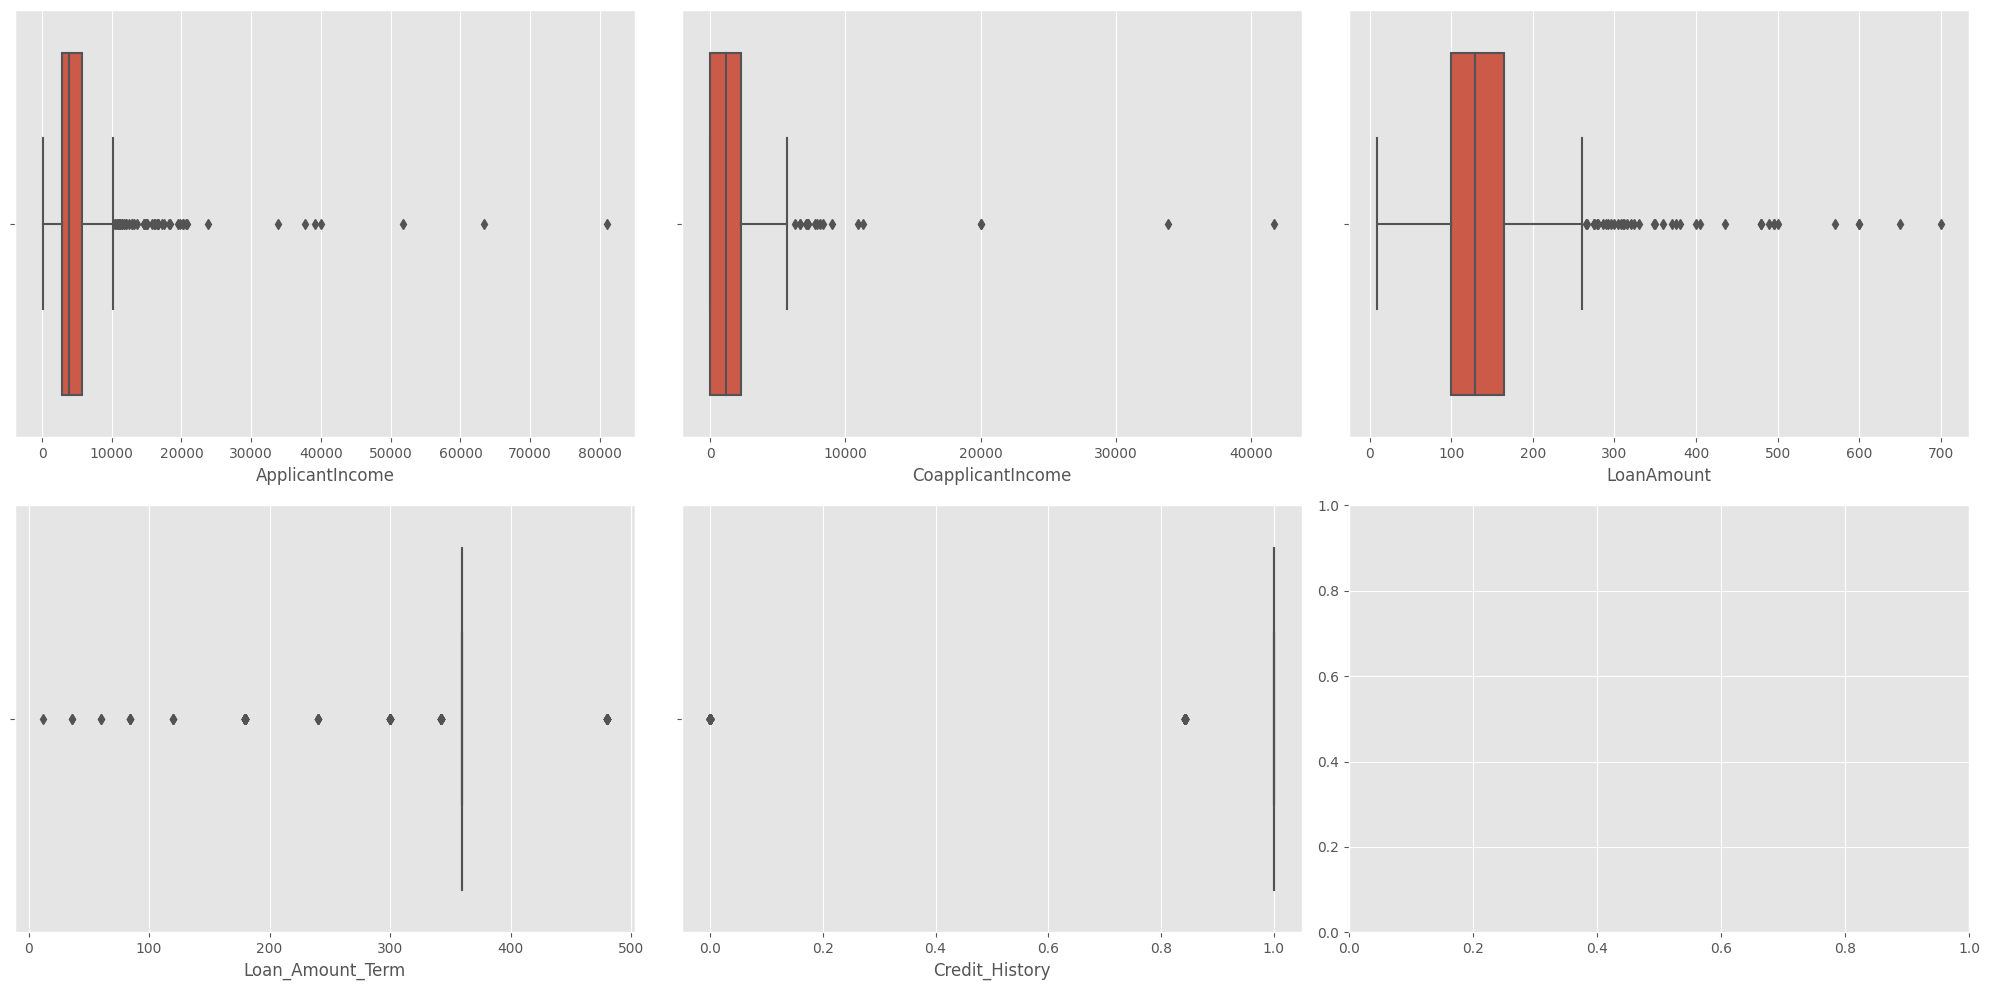

In [22]:
con_var = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
axs = axs.flatten()

for i, var in enumerate(con_var):
  sns.boxplot(x=var, data=df, ax=axs[i])

fig.tight_layout()
plt.show()

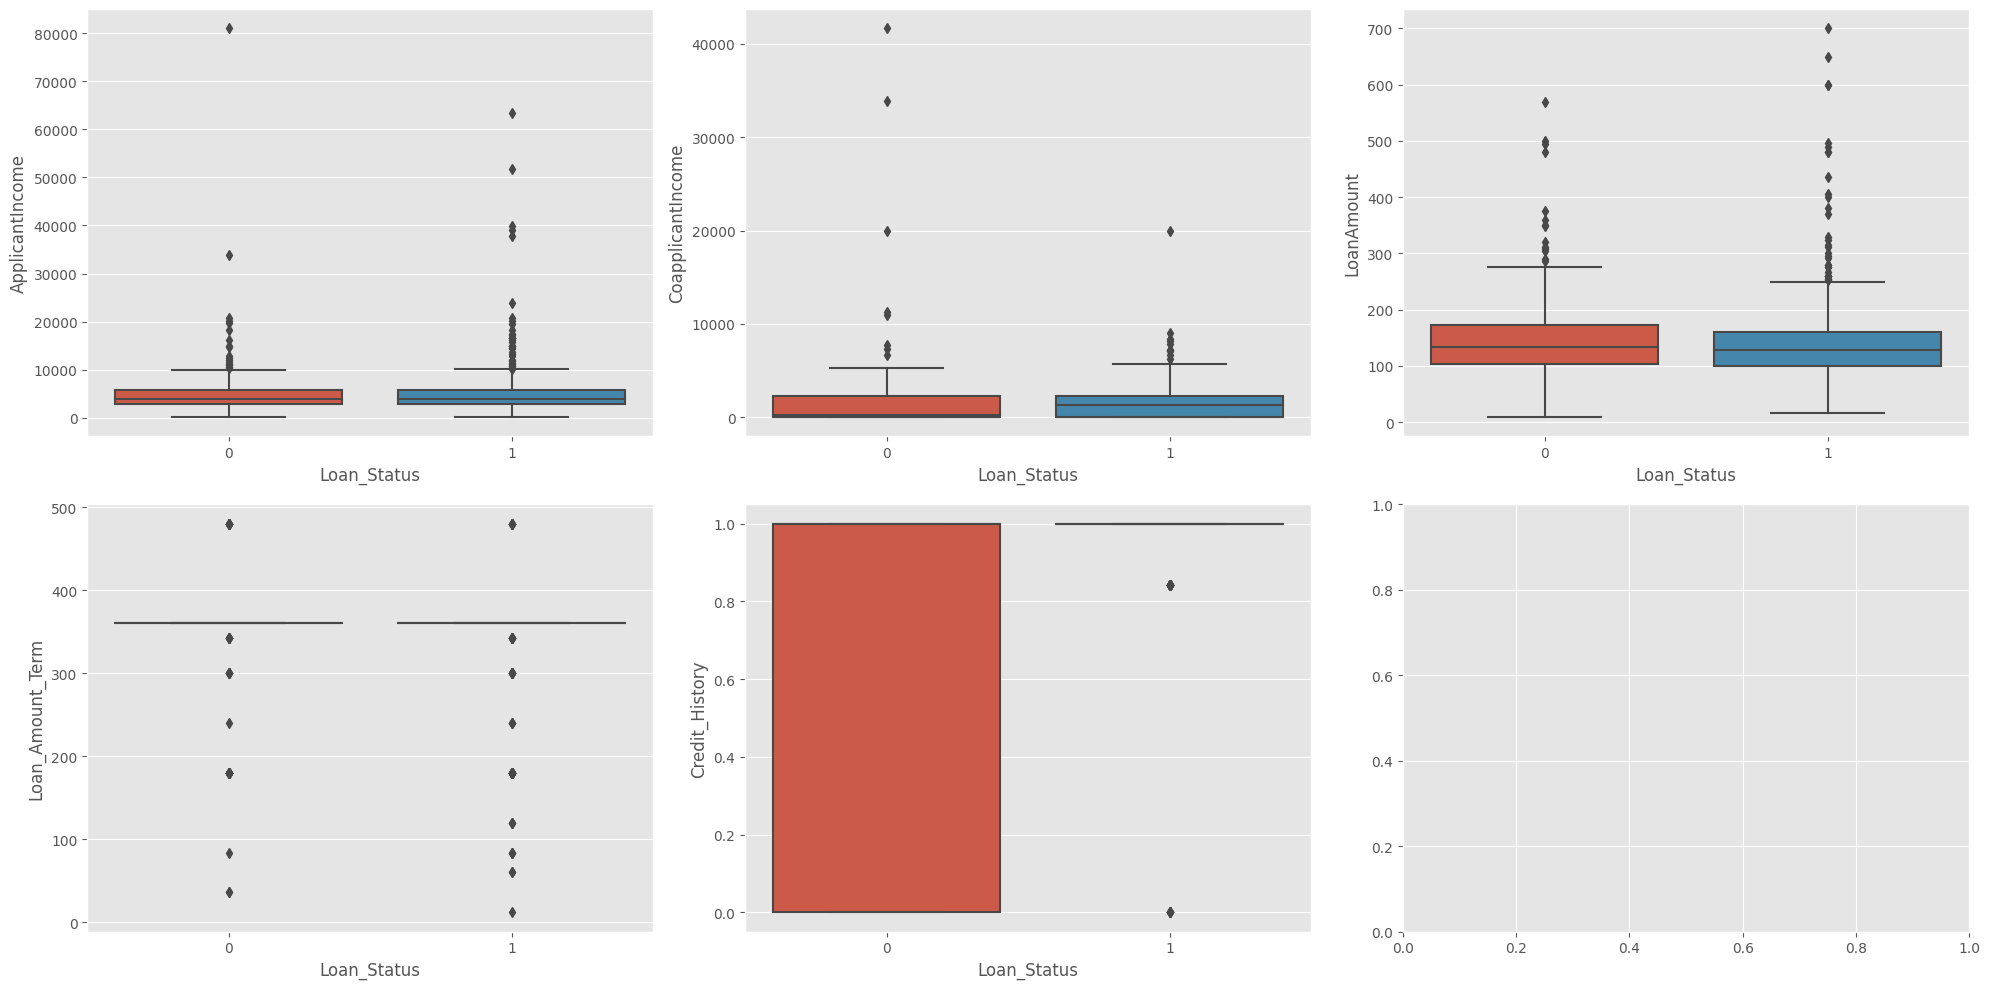

In [23]:
con_var = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
axs = axs.flatten()

for i, var in enumerate(con_var):
  sns.boxplot(y=var, x='Loan_Status', data=df, ax=axs[i])

fig.tight_layout()
plt.show()

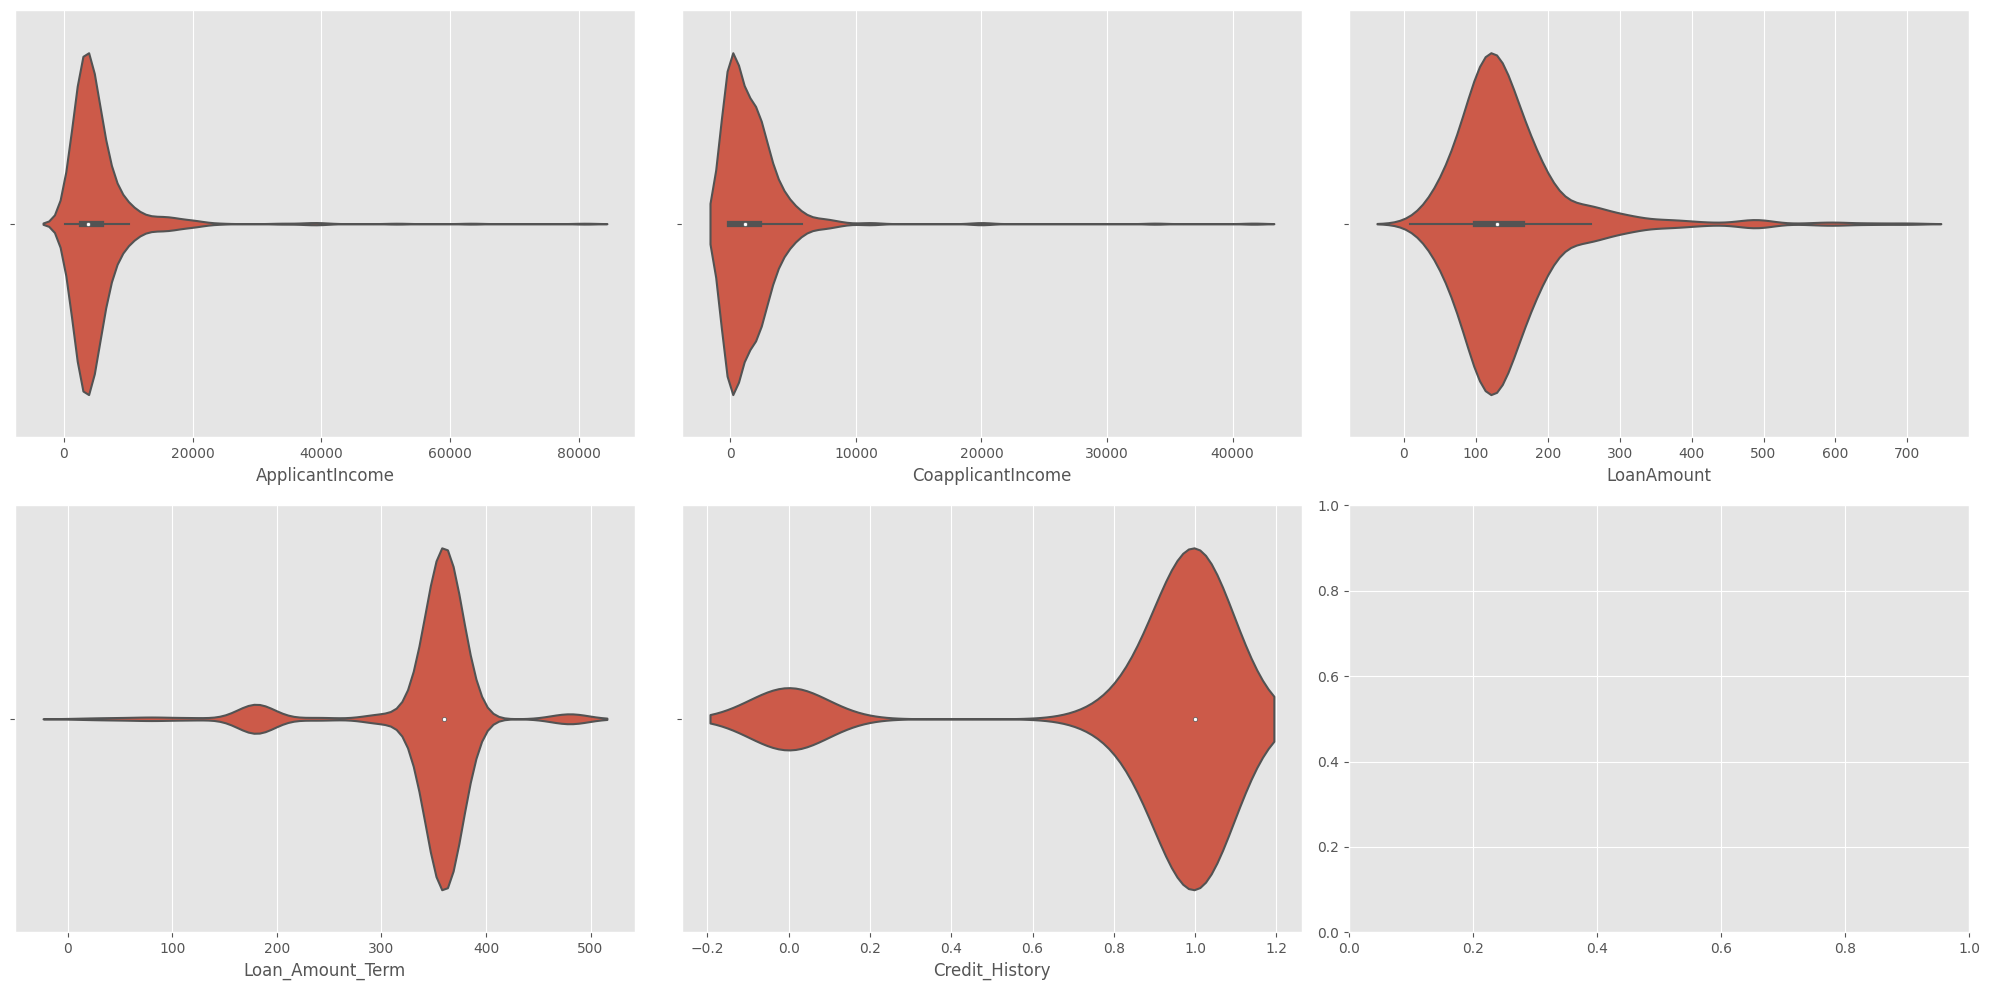

In [24]:
con_var = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
axs = axs.flatten()

for i, var in enumerate(con_var):
  sns.violinplot(x=var, data=df, ax=axs[i])

fig.tight_layout()
plt.show()

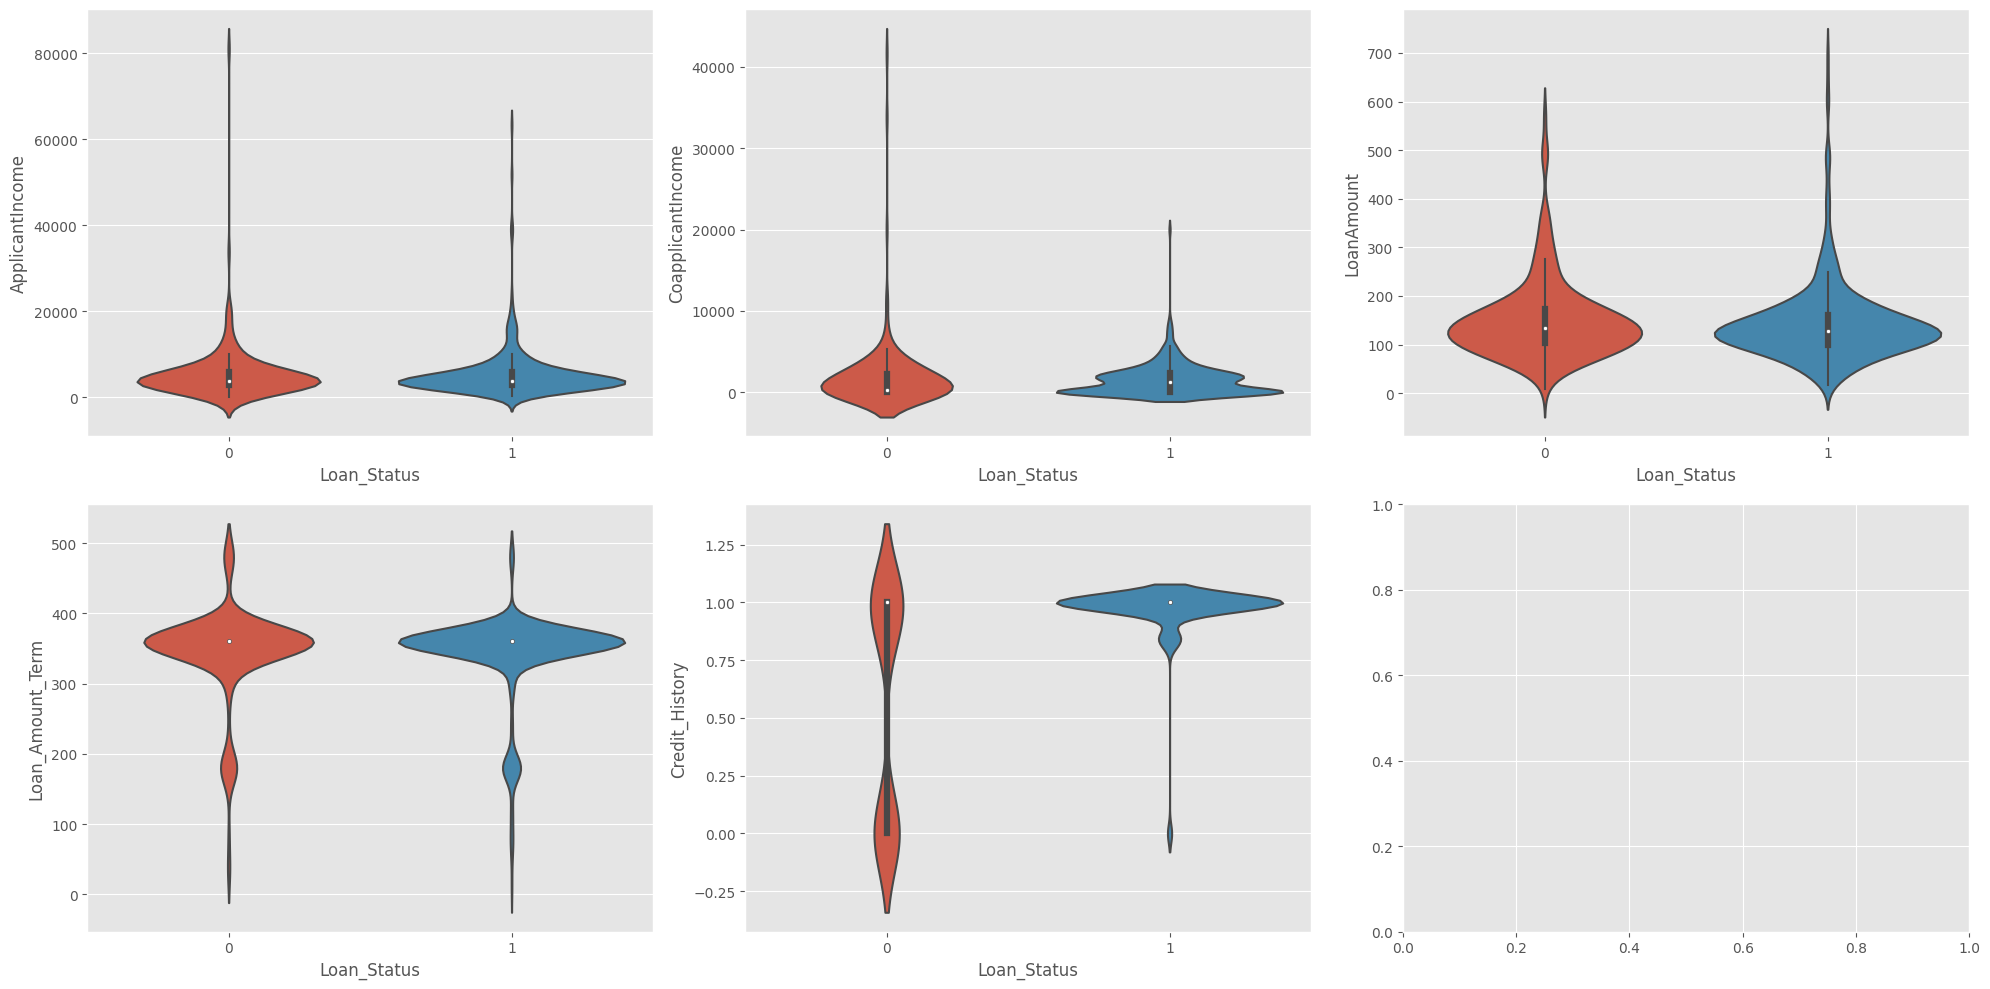

In [25]:
con_var = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
axs = axs.flatten()

for i, var in enumerate(con_var):
  sns.violinplot(y=var, x='Loan_Status', data=df, ax=axs[i])

fig.tight_layout()
plt.show()

## Feature selection and transformation

Counter({1: 422, 0: 192})

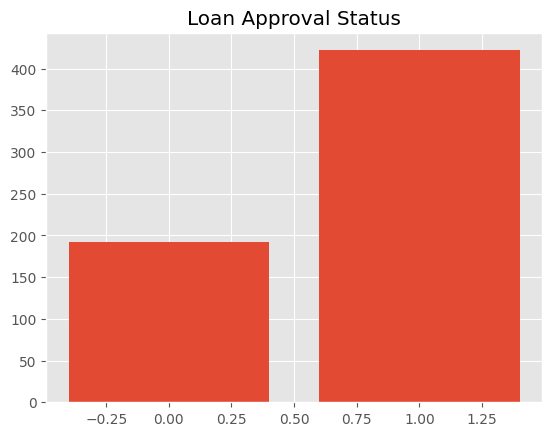

In [26]:
##==== check if label is unbalanced =================
loan_count = df['Loan_Status'].value_counts()
plt.bar(loan_count.index,loan_count.values, align='center')
plt.title('Loan Approval Status')
#sns.countplot(df['Loan_Status'])
Counter(df.Loan_Status)

**Encoding categorical variables**

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_encode = df[['Education','Dependents','Self_Employed', 'Gender', 'Married', 'Property_Area']]

df[['Education','Dependents','Self_Employed', 'Gender', 'Married', 'Property_Area']] = df_encode.apply(le.fit_transform)

#=========save encode feature=================
output = open('label_encoder.pkl', 'wb')
pickle.dump(le, output)
output.close()

#label_encoder = joblib.load('label_encoder.pkl')  # Load the saved LabelEncoder object
#new_data_encoded = new_data[['column1', 'column2', 'column3']].apply(label_encoder.transform)

In [28]:
##========== using chi-square to check how categorical input data affect target value==============
from sklearn.feature_selection import chi2

cat_data = df[['Education','Dependents','Self_Employed', 'Gender', 'Married', 'Property_Area']]
y = df["Loan_Status"]

# returns f-score and p value
f_score = chi2(cat_data, y)

In [29]:
p_value = pd.Series(f_score[1], index = cat_data.columns)

#sort p value
p_value = p_value.sort_values(ascending = True)

#print p value
print(p_value)

Education        0.059887
Married          0.181852
Property_Area    0.538763
Dependents       0.769387
Gender           0.849032
Self_Employed    0.931982
dtype: float64


In [30]:
""""NULL Hypthesis: Features are indepedent of each other
    if we accept Null hypothersis it means their is no relationship between
    the variables/features"""

significance_level = 0.05
for i in p_value.index:
  if p_value[i] <= significance_level:
    print(i, '  :- Reject NULL HYPOTHESIS')
  else:
    print(i, '  :- Accept NULL HYPOTHESIS')

Education   :- Accept NULL HYPOTHESIS
Married   :- Accept NULL HYPOTHESIS
Property_Area   :- Accept NULL HYPOTHESIS
Dependents   :- Accept NULL HYPOTHESIS
Gender   :- Accept NULL HYPOTHESIS
Self_Employed   :- Accept NULL HYPOTHESIS


**Correlation heatmap**

<Axes: >

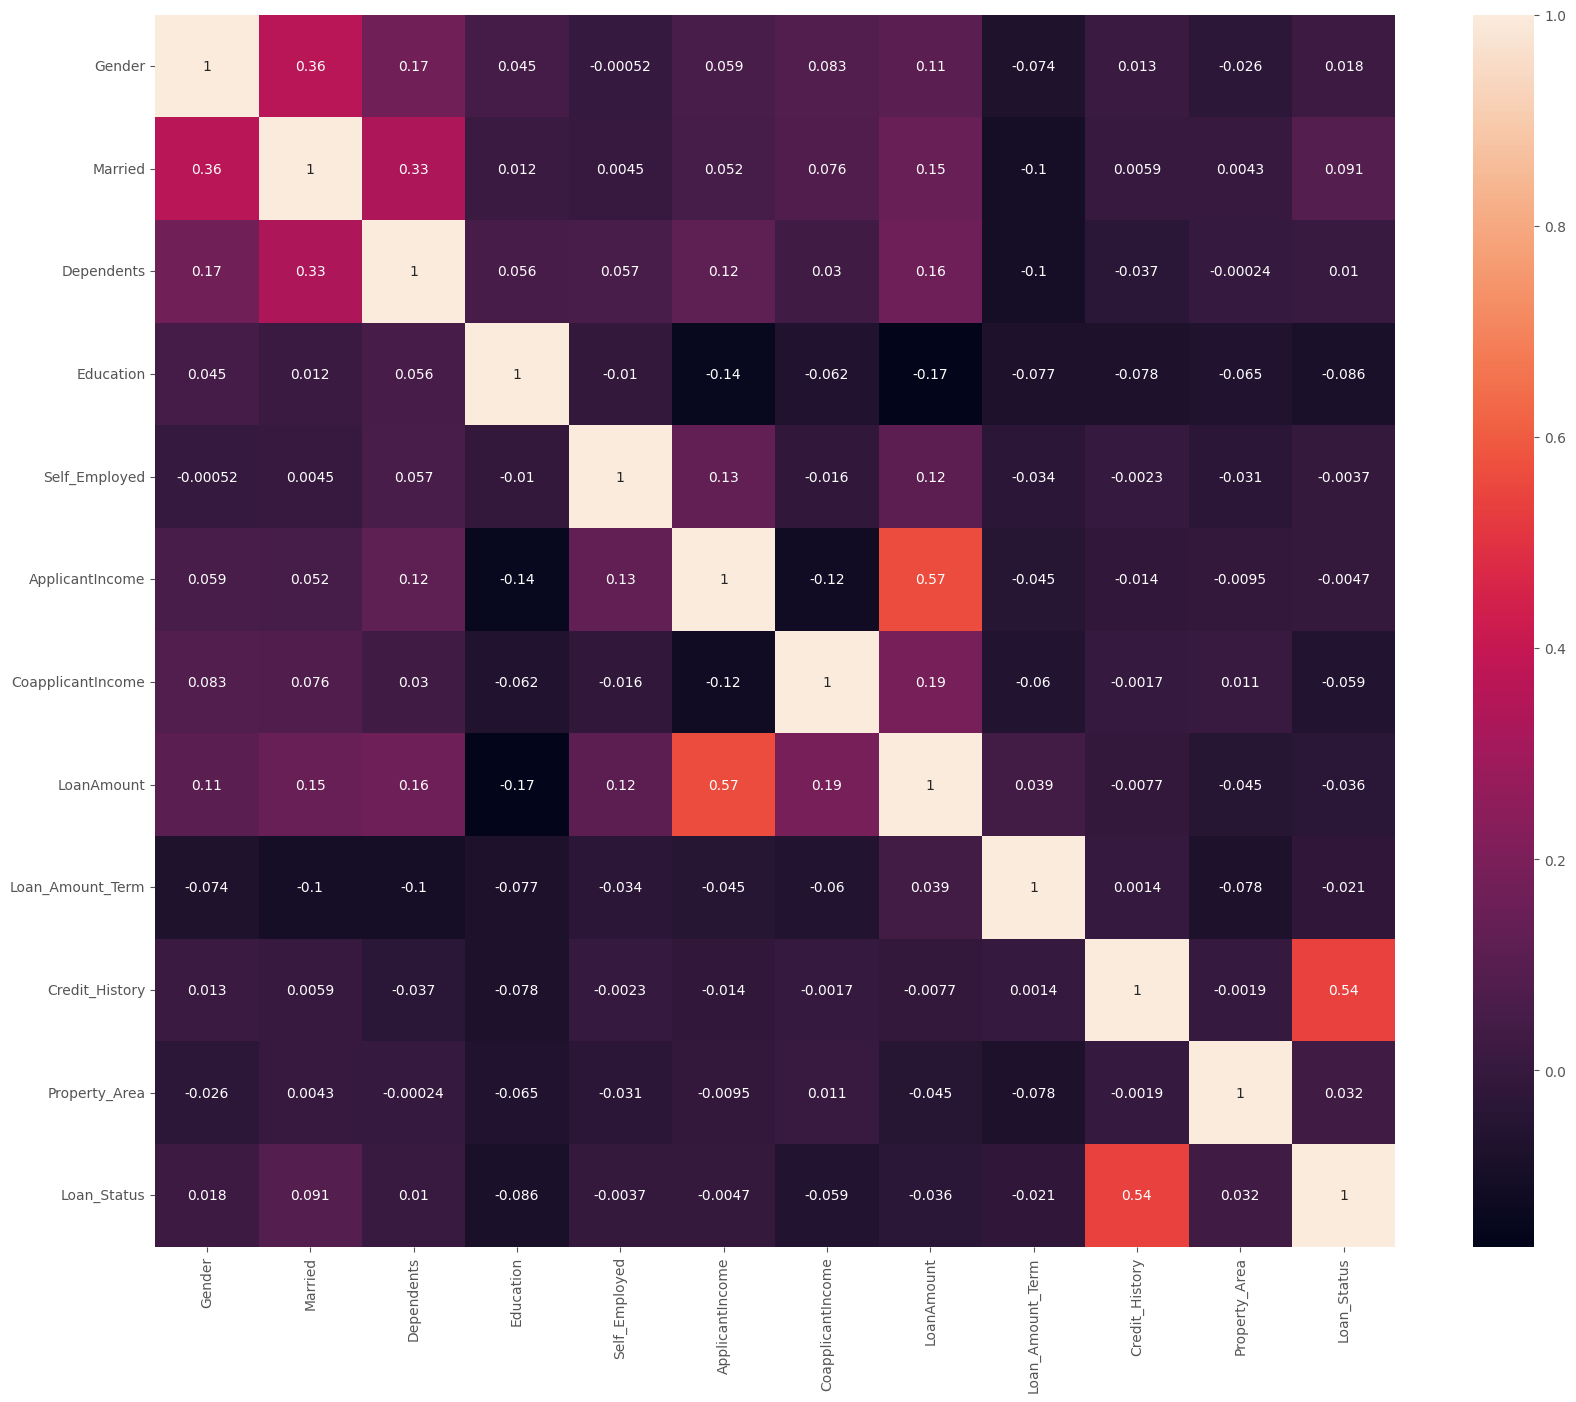

In [31]:
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), fmt='.2g', annot=True)

Text(0.5, 1.0, 'LOAN_STATUS Correlation')

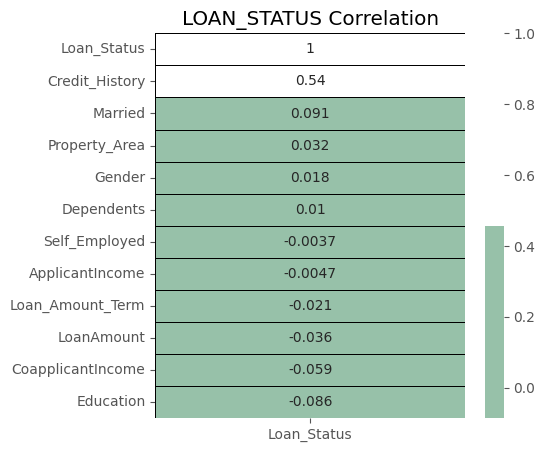

In [32]:
##========= correlation map ====================================
#plt.figure(figsize=(8, 12))
#heatmap = sns.heatmap(df.corr()[['Loan_status']].sort_values(by='target'), ascending=False)
#heatmap.set_title('Feature correlating with target', fontdict={'fontsize':18})

##==========displaying top influencing factors=============

corr = df.corrwith(df['Loan_Status']).sort_values(ascending = False).to_frame()
corr.columns = ['Loan_Status']

plt.subplots(figsize = (5,5))
sns.heatmap(corr, annot = True,cmap=colors, linewidth = 0.4, linecolor = 'black');
plt.title('LOAN_STATUS Correlation')

**Handle unbalanced dataset**

In [34]:
from sklearn.utils import resample
#Counter({1: 422, 0: 192})

df_minority = df[df['Loan_Status']==0]
df_majority = df[df['Loan_Status']==1]

df_minority_upsampled = resample(df_minority, replace=True,
                                 n_samples=422, random_state=0)

df_upsampled = pd.concat([df_minority_upsampled, df_majority])
print(df_upsampled['Loan_Status'].value_counts())

# reset axis
df_upsampled.reset_index(drop=True ,inplace=True)

0    422
1    422
Name: Loan_Status, dtype: int64


In [35]:
#======= Remove outliers using Z-score test ================
from scipy import stats

cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
z_scores = np.abs(stats.zscore(df_upsampled[cols]))

data_clean = df_upsampled[(z_scores<3).all(axis=1)]

data_clean.shape
#=======set thresold=========================================
#threshold=3

#========== find the indices of the outliers ================

#outlier_indices = np.where(z_scores > threshold)[0]

#remove outliers from the training data
#x_train = x_train.drop([x_train.index[outlier_indices]])
#y_train = y_train.drop([y_train.index[outlier_indices]])

(791, 12)

In [36]:
##
sample_X=data_clean.drop('Loan_Status', axis=1)
sample_y=data_clean['Loan_Status']

In [ ]:
#==============split==================
x_train, x_test, y_train, y_test = train_test_split(sample_X, sample_y, test_size=0.25,random_state=40)
x_train

In [38]:
#==========normalise numerical columns==========

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

#=========save scaler feature=================
output = open('scaler_input.pkl', 'wb')
pickle.dump(scaler, output)
output.close()

In [ ]:
x_train

## Modeling

In [53]:
def model(classifier, x_train, y_train):
  sns.set(rc={'figure.figure':(5,3)})
  sns.set(style='whitegrid')
  classifier.fit(x_train, y_train)
  prediction = classifier.predict(x_test)
  cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
  print('Cross Validation Score : ', '{0:.2%}'.format(cross_val_score(classifier, x_train, y_train, cv=cv)))
  print('ROC_AUC Score : ','{0.2%}'.format(roc_auc_score(y_test,prediction)))
  #plot_roc_curve
  RocCurveDisplay.from_estimator(classifier, x_test, y_test)
  plt.title('ROC_AUC_Plot')
  plt.show()


def train_model(classifier, x_train, y_train,  x_test, y_test):

  classifier.fit(x_train, y_train)
  prediction = classifier.predict(x_test)
  cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
  cv_score = cross_val_score(classifier, x_train, y_train, cv=cv)
  roc_score = roc_auc_score(y_test,prediction)
  #print(f'Cross Validation Score : {cv_score}')
  #print('ROC_AUC Score : {0.2%}'.format())
  return round(cv_score.mean(), 2), round(roc_score, 2)

In [82]:
from sklearn.metrics import accuracy_score

def model_evaluation(classifier, x_test, y_test):
  # xgboost accuracy score
  y_pred = classifier.predict(x_test)
  print('Accuracy Score :', round(accuracy_score(y_test, y_pred)*100, 2), "%")
  #Confusion_Matrix
  cm = confusion_matrix(y_test, y_pred)
  names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  counts = [value for value in cm.flatten()]

  percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cm, annot = labels, cmap = 'Blues', fmt = '')
  print(classification_report(y_test, y_pred))

In [57]:
##===== Training ================================

classifier_xgb = XGBClassifier(random_state=1)
classifier_lgbm = LGBMClassifier(random_state=1)
classifier_lr = LogisticRegression(random_state=1)
svc = SVC()
dtree = DecisionTreeClassifier(class_weight='balanced')
classifier_grad = GradientBoostingClassifier(random_state=1)

model_list = [classifier_xgb, classifier_lgbm, classifier_lr, svc, dtree, classifier_grad]
model_name = ['XGB_classifier', 'LGBM_classifier', 'LR', 'SVC','dtree', 'GRB']
CV_score, ROC_AUC_Score = [], []

for i, md in enumerate(model_list):
  CV, ROC = train_model(md, x_train, y_train, x_test, y_test)
  print(f' {model_name[i]} cv_score is: {CV} and ROC is: {ROC}')
  #CV_score.append(CV)
  #ROC_AUC_Score.append(ROC)

#df = pd.DataFrame({"name":model_name, "CV_Score":CV_score, "ROC_AUC_Score":ROC_AUC_Score})
#print('The information below shows the models comparison')
#print(df)

 XGB_classifier cv_score is: 0.86 and ROC is: 0.89
 LGBM_classifier cv_score is: 0.87 and ROC is: 0.89
 LR cv_score is: 0.72 and ROC is: 0.75
 SVC cv_score is: 0.76 and ROC is: 0.79
 dtree cv_score is: 0.81 and ROC is: 0.88
 GRB cv_score is: 0.81 and ROC is: 0.85


**Hyparameter tunning for LGBM_classifier**

In [83]:
#=== Select the best performance model and fine tune its parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt', 'dart'],
    'objective' : ['binary'],
    'max_bin':[255, 510],
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],

    }

# Perform grid search GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)
grid_search = GridSearchCV(classifier_lgbm, param_grid,verbose=1, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

#print best parameters
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits
{'boosting_type': 'dart', 'colsample_bytree': 0.64, 'learning_rate': 0.01, 'max_bin': 510, 'n_estimators': 24, 'num_leaves': 16, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.7403218914684518


In [84]:
params = grid_search.best_params_
type(params)

dict

In [85]:
#== final training with the tuned hyperparameters


lgbm = LGBMClassifier(**params)
lgbm.fit(x_train, y_train)



LGBMClassifier(boosting_type='dart', colsample_bytree=0.64, learning_rate=0.01,
               max_bin=510, n_estimators=24, num_leaves=16, objective='binary',
               random_state=500, reg_alpha=1, reg_lambda=1, subsample=0.7)

Accuracy Score : 75.76 %
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       101
           1       0.73      0.80      0.76        97

    accuracy                           0.76       198
   macro avg       0.76      0.76      0.76       198
weighted avg       0.76      0.76      0.76       198



Text(0.5, 1.0, 'ROC_AUC_Plot')

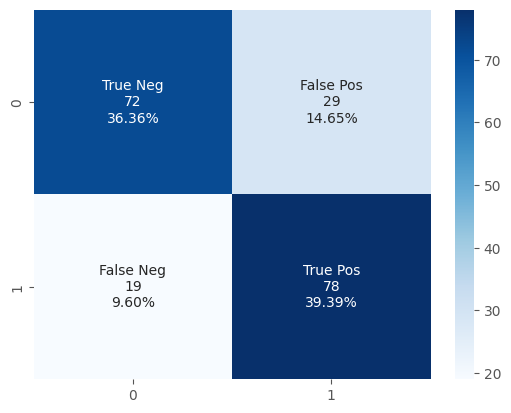

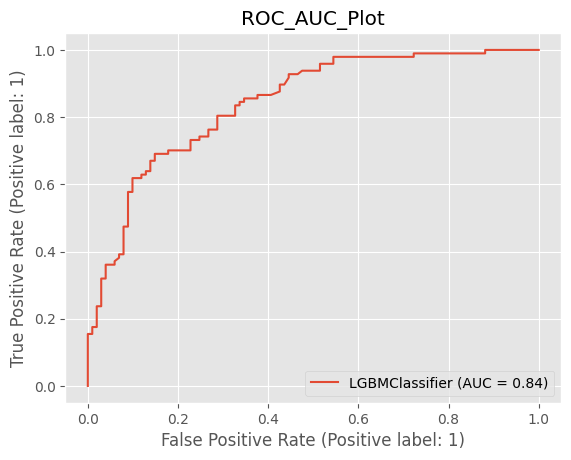

In [86]:
#Model report
model_evaluation(lgbm, x_test, y_test)

RocCurveDisplay.from_estimator(lgbm, x_test, y_test)
plt.title('ROC_AUC_Plot')

In [87]:
from xgboost.sklearn import XGBRFClassifier
# tunning xgboost

param_grid = {
    'n_estimator': [100, 200],
    'max_depth': [3,5,7],
    'learning_rate': [0.1,0.01,0.01],
    'gamma':[0,0.1,0.2]
}
xgb = XGBClassifier()
grid_search = GridSearchCV(xgb, param_grid, verbose=1, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

#print best parameters
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[13:42:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimator': 100}
0.8684517874946589


In [88]:
params = grid_search.best_params_

xgb = XGBClassifier(**params)
xgb.fit(x_train, y_train)


[13:42:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimator=100, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

Accuracy Score : 89.9 %
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       101
           1       0.91      0.88      0.89        97

    accuracy                           0.90       198
   macro avg       0.90      0.90      0.90       198
weighted avg       0.90      0.90      0.90       198



Text(0.5, 1.0, 'ROC_AUC_Plot')

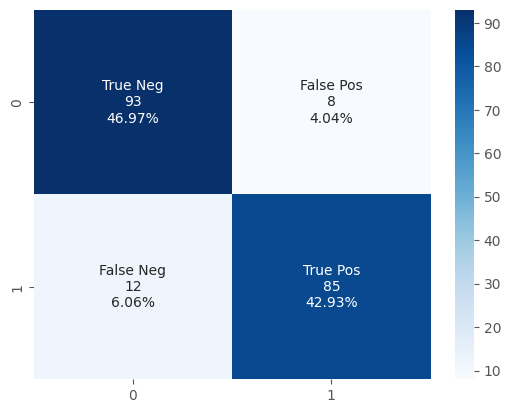

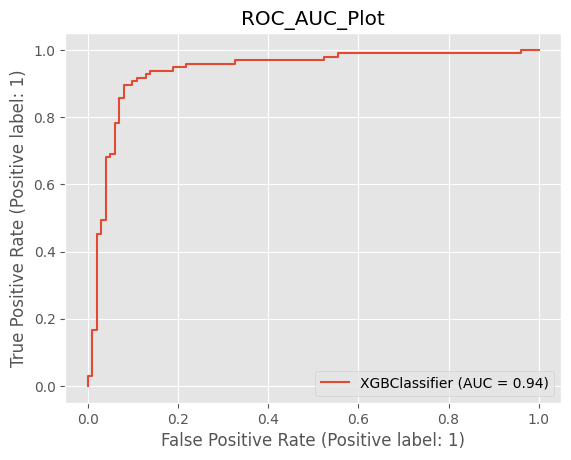

In [89]:
#Model report
model_evaluation(xgb, x_test, y_test)

RocCurveDisplay.from_estimator(xgb, x_test, y_test)
plt.title('ROC_AUC_Plot')

##Conclusion

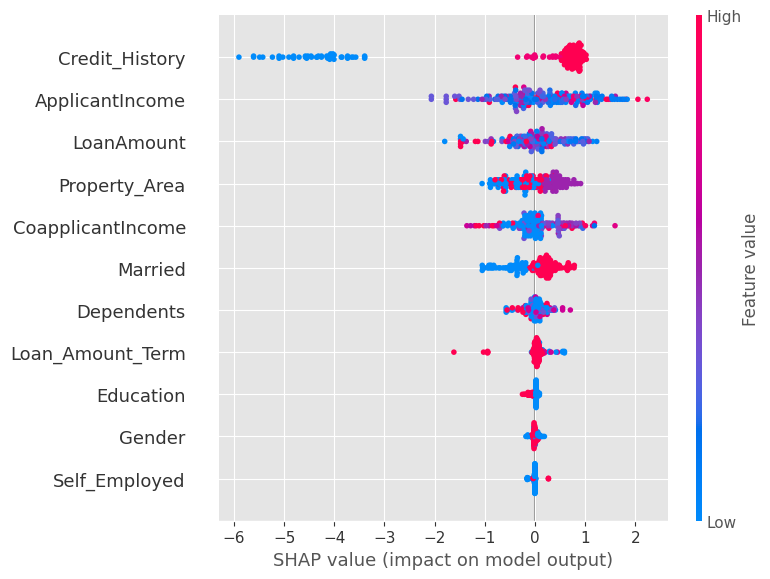

In [90]:
"""NB: xgb is the trained model"""
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)

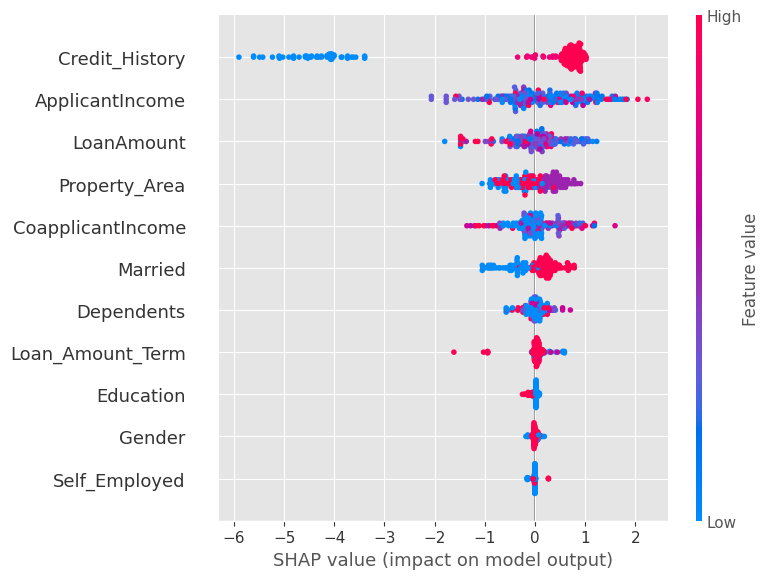

In [94]:
#compute SHAP values
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test.values, feature_names = x_test.columns)

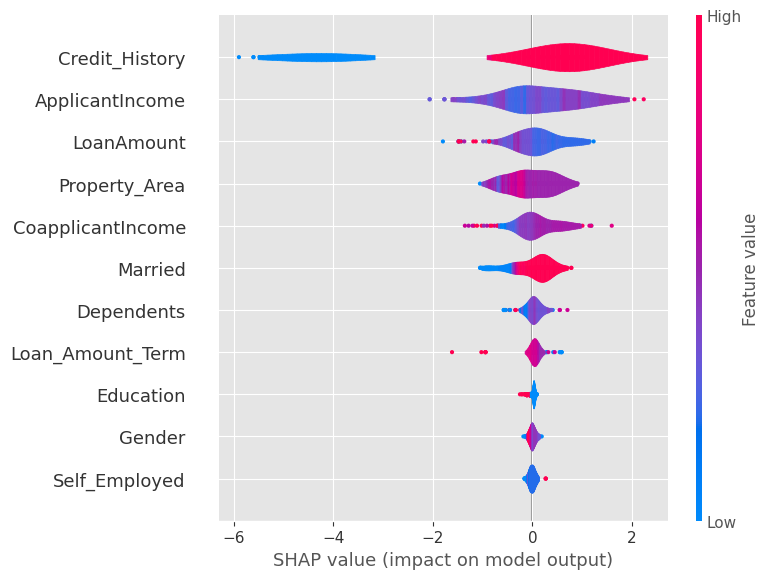

In [103]:
#compute SHAP values
explainer = shap.Explainer(xgb)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test.values, feature_names = x_test.columns, plot_type='violin')

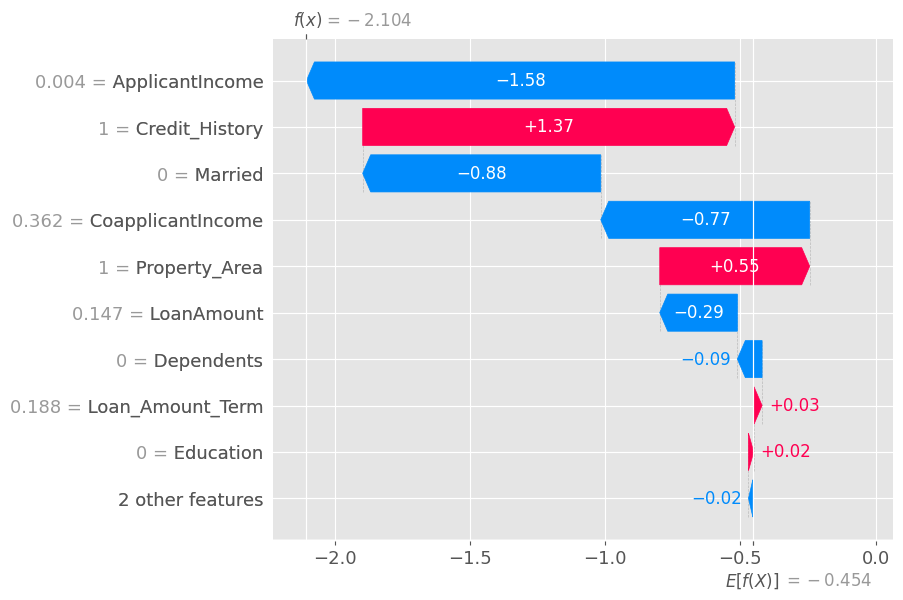

In [104]:
#compute SHAP values
explainer = shap.Explainer(xgb, x_test)
shap_values = explainer(x_test)
shap.plots.waterfall(shap_values[0])

In [105]:
# Save the trained model

filename = './loan_model.pkl'
pickle.dump(xgb, open(filename, 'wb'))